In [1]:
import pandas as pd
import numpy as np

In [4]:
!ls

sample_submition.csv teta-ml-1-2025.zip   Untitled.ipynb
test.csv             train.csv


In [5]:
data = pd.read_csv('train.csv')
data.head()

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0
1,2019-04-17 23:09,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.6176,-86.9475,1412,Drilling engineer,31.872266,-87.828247,0
2,2019-09-23 15:02,fraud_Ruecker-Mayert,kids_pets,52.96,Kyle,Park,M,7507 Larry Passage Suite 859,Mount Perry,OH,43760,39.8788,-82.1880,1831,Barrister's clerk,40.010874,-81.841249,0
3,2019-05-13 16:00,"fraud_Mante, Luettgen and Hackett",health_fitness,7.66,Monique,Martin,F,68276 Matthew Springs,Ratcliff,TX,75858,31.3833,-95.0619,43,"Engineer, production",30.888406,-95.141609,0
4,2019-08-18 07:27,fraud_Luettgen PLC,gas_transport,51.59,Christine,Johnson,F,8011 Chapman Tunnel Apt. 568,Blairsden-Graeagle,CA,96103,39.8127,-120.6405,1725,Chartered legal executive (England and Wales),39.376017,-121.311691,0


In [9]:
data['transaction_time'] = pd.to_datetime(data['transaction_time'])
data['hour'] = data['transaction_time'].dt.hour
data['weekday'] = data['transaction_time'].dt.weekday
data['distance'] = (data['lat'] - data['merchant_lat']) ** 2 + (data['lon'] - data['merchant_lon']) ** 2
data = data.drop(columns=['transaction_time', 'name_1', 'name_2', 'lat', 'lon', 'merchant_lat', 'merchant_lon'])

In [7]:
data['street'].value_counts()

street
4664 Sanchez Common Suite 930    1914
574 David Locks Suite 207        1907
854 Walker Dale Suite 488        1904
372 Jeffrey Course               1899
0069 Robin Brooks Apt. 695       1898
                                 ... 
056 Anthony Creek Suite 406         5
7065 Whitney Mountains              5
5560 Arnold Port Suite 880          5
492 West Crossing                   5
87896 Lisa Burgs                    4
Name: count, Length: 965, dtype: int64

In [15]:
# !pip install catboost

In [16]:
from catboost import CatBoostClassifier, Pool

python3.13(49549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [18]:
cat_cols = ['merch', 'cat_id', 'gender', 'street', 'one_city', 'us_state', 'post_code']
text_cols = ['jobs']


In [21]:
# !pip install scikit-learn

In [22]:
from sklearn.model_selection import train_test_split
(df_train, df_val) = train_test_split(data, test_size=0.2, random_state=42, )

In [24]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']

X_val = df_val.drop('target', axis=1)
y_val = df_val['target']

In [34]:
params = {'n_estimators' : 2000,
          'learning_rate': .03,
          'max_depth' : 4,
          'cat_features' : cat_cols,
          'text_features': text_cols,
          # 'auto_class_weights': 'Balanced',
          # 'border_count' : 64,
          'l2_leaf_reg' : 2,
          # 'bagging_temperature' : 2,
        #   'rsm' : .1,
          'use_best_model': False,
          # 'task_type': 'GPU',
          'random_state': 42,
         }

model = CatBoostClassifier(**params)
model.fit(X_train, y_train, verbose=500, eval_set=(X_val, y_val), early_stopping_rounds=100)

0:	learn: 0.6196173	test: 0.6196243	best: 0.6196243 (0)	total: 178ms	remaining: 5m 56s
500:	learn: 0.0078596	test: 0.0074865	best: 0.0074864 (499)	total: 1m 51s	remaining: 5m 34s
1000:	learn: 0.0067672	test: 0.0065785	best: 0.0065785 (995)	total: 3m 13s	remaining: 3m 13s
1500:	learn: 0.0063789	test: 0.0063734	best: 0.0063731 (1497)	total: 4m 29s	remaining: 1m 29s
1999:	learn: 0.0060415	test: 0.0061954	best: 0.0061950 (1998)	total: 5m 43s	remaining: 0us

bestTest = 0.006195049779
bestIteration = 1998



In [35]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(model.predict(X_val), y_val), f1_score(model.predict(X_val), y_val)

(0.9983851176511727, 0.8484486873508353)

In [36]:
import pickle

with open('catboost.pickle', 'wb') as f:
    pickle.dump(model, f)

In [49]:
pd.read_csv('test.csv')

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon
0,2019-09-14 02:46,"fraud_Stokes, Christiansen and Sipes",grocery_net,25.79,Michael,Rodriguez,M,172 Paula Inlet Apt. 650,Cross Plains,TX,76443,32.1482,-99.1872,1897,Chief Operating Officer,31.772057,-99.103183
1,2019-07-25 20:30,fraud_Thompson-Gleason,health_fitness,87.80,Curtis,Young,M,4319 Watson Shoals Suite 658,Falconer,NY,14733,42.1239,-79.1895,3833,Metallurgist,42.635312,-78.334559
2,2020-01-05 17:27,fraud_Friesen Inc,shopping_pos,10.98,Brandy,Quinn,F,9734 Beard Fields Suite 885,Altair,TX,77412,29.6047,-96.5249,106,"Editor, film/video",29.363782,-95.624994
3,2019-07-21 00:14,"fraud_Jenkins, Hauck and Friesen",gas_transport,71.97,Ashley,Mcdonald,F,3160 Tina Estates Suite 234,Marietta,SC,29661,35.0296,-82.5136,5648,Museum/gallery exhibitions officer,35.142659,-82.489028
4,2019-03-13 00:45,"fraud_Kovacek, Dibbert and Ondricka",grocery_pos,210.50,Kimberly,Rice,F,63991 Destiny Rue Apt. 651,Tyler,TX,75703,32.2768,-95.3031,144160,Sports development officer,31.833016,-94.746542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,2019-08-13 21:24,fraud_O'Keefe-Wisoky,food_dining,17.39,Scott,Martin,M,7483 Navarro Flats,Freedom,WY,83120,43.0172,-111.0292,471,"Education officer, museum",42.398393,-110.760528
262140,2019-12-19 16:35,"fraud_Runolfsdottir, Mueller and Hand",entertainment,5.29,Chris,White,M,98897 Bennett Lodge,Bessemer,AL,35022,33.3224,-86.9657,71463,Radio broadcast assistant,33.928294,-87.548646
262141,2019-07-28 14:34,fraud_Dietrich-Fadel,health_fitness,72.75,Katherine,Tucker,F,670 Le Meadows Suite 250,Lakeland,FL,33811,27.9865,-82.0139,237282,Clothing/textile technologist,28.971960,-82.465733
262142,2019-02-27 10:56,fraud_Kunze Inc,grocery_pos,50.14,Nathan,Mendoza,M,767 Adam Mill Apt. 115,Espanola,NM,87533,35.9866,-106.0654,18408,Historic buildings inspector/conservation officer,36.773361,-105.683859


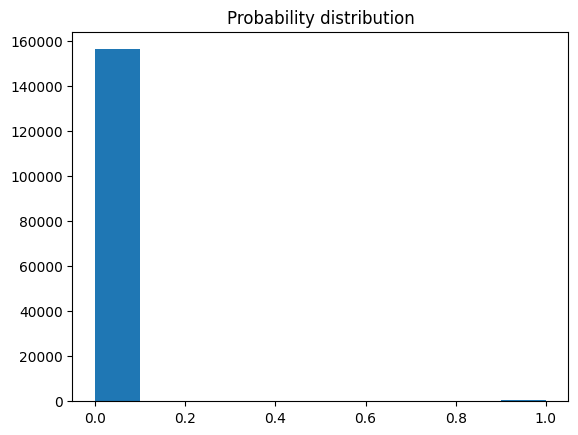

In [45]:
import matplotlib.pyplot as plt

plt.hist(model.predict_proba(X_val)[:, 1])
plt.title('Probability distribution')
plt.savefig('hist.png')